# Can We Predict Whether or Not a Person Will Recommend a Product?

For Sephora, it is natural for them to want to promote products that are recommended a lot and not promote products that are not. One of the great things about Sephora's UI is that when you have an account, they will recommend products to you. For example, my current recommendations include MAKE UP FOR EVER's Ultra HD Invisible Cover Foundation, Anastasia Beverly Hills' Brow Wiz, Givenchy's Teint Couture Blurring Foundation Balm Broad Spectrum 15, and more. I don't know how Sephora picks these recommendations for me, but I do know that I have provided Sephora with my personal information including skin tone, skin type, skin concerns, age, and other features. What we are going to attempt to do in this notebook is to see if we can use machine learning to predict whether or not any given person will recommend a product based on the product and the person's characteristics. If a person is more likely to recommend a product based on their characteristics, then it makes sense to recommend that product to them. 

We will attempt to this using three different machine learning algorithms, which we will go into more detail about later. These algorithms are: 
 - Logistic Regression
 - k Nearest Neighbors (kNN)
 - Support Vector Machine (SVM)
 
 We will compare the results of these algorithms to see which one provides the highest success rate.

## Table of Contents

1. [Imported Packages](#imported)
2. [Data](#data)
3. [Data Exploration](#dataexploration)
    <br>3.1 [Categorical Data](#categoricaldata)<br>
4. [Prepare Data](#preparedata)
    <br>4.1 [Converting Categorical Data into Dummy Variables](#convert)
    <br>4.2 [Over-Sampling Our Data Using SMOTE](#smote)<br>
5. [Machine Learning Algorithms](#machinelearning)
    <br>5.1 [Logistic Regression](#logreg)
    <br>5.2 [k-Nearest Neighbors](#knn)
    <br>5.3 [Support Vector Machine](#svm)
6. [Conclusion](#conclusion)

## Imported Packages
<a id = 'imported'></a>

In [131]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
import plotnine as p9
from plotnine import *
from imblearn.over_sampling import SMOTE

## Data
<a id = 'data'></a>

The data we are working with is the same data as we were using in the last notebook except we are not going to be working with all of the features. We obviously will not be needing the image urls that were used for plotting in the last notebook. In this section, I will clean the data up a bit and then display some visualizations that show how different features interact with the recommendation column. 

In [2]:
warnings.filterwarnings("ignore")

#read in data frame
df = pd.read_csv('/Users/sangeetharamamurthy/Desktop/SephoraFoundationAnalysis/Datasets/sephora_reviews_final.csv')

df = df[['brand','name','skin_type', 'skin_concerns',
        'skin_tone', 'age', 'price', 'recommended']]


df = df[~df['recommended'].isna()]

#0: Not recommended
#1: Recommended
df['recommended'] = [1 if i  == True else 0 for i in df['recommended']]

**Input Variables**
 - **name**: name of foundation (categorical)
 - **skin_type**: the type of skin a person has (categorical; e.g. oily, combination, etc.)
 - **skin_concerns**: what the person is most concerned about with their skin (categorical; e.g. acne, aging, etc.)
 - **skin_tone**: what color complexion a person has (categorical; e.g. dark, light, ebony, etc.)
 - **age**: a person's age (categorical; e.g. 13to17, 18to24, etc.)
 - **price**: price of the foundation (numeric)
 
**Predict Variable**
 - **recommended**: has the reviewer recommended the product? (binary; 0: no, 1: yes)
 
 **Note**: We do not have recommended values for all of the data because many people do not provide their recommendation on the product when they review it. Thus, we will be dropping all the data that does not have recommended information, and we are assuming that recommendation data is missing completely at random. In addition, because we turned age into a numeric fetaure by using one hot encoding, we had to drop all rows without age information.

## Data Exploration
<a id = 'dataexploration'></a>

In [50]:
df['recommended'].value_counts()[0]/len(df), df['recommended'].value_counts()[1]/len(df)

(0.2089784229013426, 0.7910215770986574)

Percentage of not recommending a product: 20.89784229013426%

Percentage of recommending a product: 79.10215770986574%

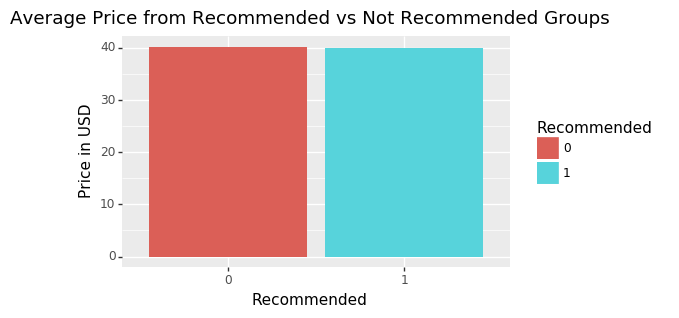

<ggplot: (-9223372036582811304)>

In [51]:
df_price = df.groupby('recommended').mean()
df_price['recommended'] = df_price.index.astype(str)

(p9.ggplot(df_price, aes(x = 'recommended', y = 'price', fill = 'recommended')) + 
 geom_bar(stat = 'identity') + 
 theme(figure_size = (5,3)) + 
 ggtitle('Average Price from Recommended vs Not Recommended Groups') + 
 labs(fill = 'Recommended') + 
 xlab('Recommended') + 
 ylab('Price in USD'))

There does not seem to be a major difference between the average price of foundations that were recommended compared to foundations that were not recommended. However, their is a huge divergence in rating between recommended and not recommended products. The average rating of a product that was not recommended is almost 3 points lower than the average rating of a recommended product.

Now, I am going to calculate categorical means for my categorical variables like skin tone, skin type, age, and more.

Clearly, age does not seem to have much of an impact on recommendation either because there is no difference between the two. However, we will see what happens as we move forward.

### Categorical Data
<a id = 'categoricaldata'></a>

#### Age

In [52]:
df.groupby('age').mean()

,price,recommended
age,,
13to17,38.947134,0.777070
18to24,39.703243,0.772536
25to34,40.718795,0.764514
35to44,40.609492,0.781015
45to54,41.608000,0.794667
over54,39.793400,0.766727


Age does not seem to have much of an impact on recommendation.

#### Skin Type

In [53]:
df.groupby('skin_type').mean()

,price,recommended
skin_type,,
combination,39.987103,0.791436
dry,41.043926,0.778631
normal,39.968731,0.806893
oily,39.268809,0.780632


Skin type also seems to not have much of an impact on whether or not someone will recommend a product. However, people with normal and combination skin tend to recommend more than people with dry or oily skin. This is probably because most foundations try to gear their products to everyone, which means that it's tougher for people with dry/oily skin to find foundations that specifically deal with their skin issues. 

In [54]:
df.groupby('skin_concerns').mean()

,price,recommended
skin_concerns,,
acne,39.672985,0.786904
aging,41.368924,0.796479
blackheads,39.698023,0.806755
calluses,38.806452,0.838710
cellulite,39.592126,0.823622
cuticles,39.804348,0.804348
darkCircles,39.973344,0.819602
dullness,41.550815,0.779482
pores,39.523715,0.766798


Skin concerns, so far, do seem to show a little bit of difference in recommendation averages. While it is minimal, it worth nothing that people who have calluses and cellulite are the most likely to recommend a product. That may be because those skin concerns have nothing to do with face problems, and so those people do not have as many skin concerns about their face, and thus, are more open to certain items.

In [55]:
df.groupby('skin_tone').mean()

,price,recommended
skin_tone,,
dark,38.870563,0.873457
deep,39.383094,0.868759
ebony,38.942500,0.898333
fair,39.951922,0.752021
light,40.336194,0.773799
medium,40.299719,0.804222
olive,40.642492,0.827680
porcelain,39.339095,0.706139
tan,39.583477,0.837745


Skin tone seems to change the recommended average a little more as well. One surprising feature is that people with darker skin tend to recommend products more, while people with lighter skin tend to be a little less likely to recommend products.

#### Brand Name

In [56]:
df.groupby('brand').mean()

,price,recommended
brand,,
AMOREPACIFIC,61.269841,0.833333
Anastasia Beverly Hills,25.000000,0.666129
Antonym,44.611111,0.722222
BECCA,43.866135,0.755378
BURBERRY,49.395349,0.744186
Benefit Cosmetics,31.730415,0.788018
Black Up,41.065217,0.782609
Bobbi Brown,47.186016,0.750660
CLINIQUE,29.756694,0.770081


From the grouped data frame above, it looks  like brand does play an important role in whether or not people will recommend a product. For example, Cinema Secrets only has an average of 0.5000, which is well below the global average of 77% recommended.

In [57]:
df.groupby('name').mean()

,price,recommended
name,,
#FauxFilter Foundation,40.0,0.660852
10 HR Wear Perfection Foundation,20.0,0.780711
8 HR Mattifying Compact Foundation,20.0,0.900000
Acne Solutions BB Cream Broad Spectrum SPF 40,39.0,0.815068
Acne Solutions Liquid Makeup,29.0,0.838462
Age Defense BB Cream Broad Spectrum SPF 30,39.0,0.600000
All Day Luminous Weightless Foundation,49.0,0.640669
All Hours Longwear Natural Matte Foundation,54.0,0.799743
All Hours Stick Foundation,48.0,0.909091


When we make our products features in the data, we see the largest amount of variation between recommendation averages. This is because the product is the most important part in whether or not someone will recommend an item.

## Prepare Data
<a id = 'preparedata'></a>

### Converting Categorical Data into Dummy Variables
<a id = 'convert'></a>

In [3]:
df = pd.get_dummies(df, columns=['brand','name','skin_type', 'skin_tone', 'skin_concerns','age'], 
                    prefix=['brand','name','skin_type', 'skin_tone','skin_concerns','age'])

### Over-sampling Our Data Using SMOTE
<a id = 'smote'></a>

With the training data, we are going to over-sample the 'no-recommendation' group using the SMOTE algorithm (Synthetic Minority Oversampling Technique). It works by creating synthetic samples from the minority class, which in are case, is the 'no-recommendation' group, but it doesn't do it by making copies. It randomly chooses one of the k-Nearest Neighbors and uses it to recreate similar (with some randome changes) observations. 

In [110]:
#code from: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X = df.loc[:, df.columns != 'recommended']
y = df.loc[:, df.columns == 'recommended']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

#Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no recommendation in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of recommendation",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no recommendation data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of recommendation data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Length of oversampled data is  103462
Number of no recommendation in oversampled data 51731
Number of recommendation 51731
Proportion of no recommendation data in oversampled data is  0.5
Proportion of recommendation data in oversampled data is  0.5


## Machine Learning Algorithms
<a id='machinelearning'></a>

The fun part finally begins.

### Logistic Regression
<a id = 'logreg'></a>

Because we are trying to predict a binary outcome (either a person will recommend or not recommend a product), it seemed like an obvious choice to use logistic regression as one of our algorithms. 

The first thing we want to do, however, is use recursive feature elimination to select features that actually have an impact.

#### Recursive Feature Elimination

In [5]:
data_final=df.columns.values.tolist()
y=['recommended']
X=[i for i in data_final if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False  True  True False False False False
 False False  True False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False  True  True
 False False False False False False False  True Fa

In [8]:
cols = [data_final[i] for i in range(315) if rfe.support_[i] == True]
X = os_data_X[cols]
y = os_data_y['y']

In [9]:
cols

['name_All Hours Longwear Natural Matte Foundation',
 'name_Black Label Detox BB Beauty Balm',
 'name_DUAL FINISH – Multi-tasking Longwear Powder Foundation',
 'name_DayWear BB Anti-Oxidant Beauty Benefit Crème SPF 35',
 'name_Diorskin Nude Air Serum Foundation',
 'name_Double Wear Stay-in-Place Powder Foundation',
 'name_Fresh Glow Foundation Gel Stick Foundation & Concealer',
 'name_Lingerie de Peau Aqua Nude Foundation',
 'name_Lingerie de Peau BB Cream',
 'name_MOISTURE BOUND Tinted Treatment Moisturizer SPF 15',
 'name_Make No Mistake Foundation & Concealer Stick',
 'name_Nothing Beats the Original™ Complexion Kit',
 'name_Rōsilliance™ Organic BB+ Cream SPF 30',
 'name_Teint Idole Ultra Longwear Cushion Foundation SPF 50',
 'name_Tenue de Perfection Long-lasting Liquid Foundation',
 'name_Terracotta  Healthy Glow Liquid Foundation SPF 20',
 'name_Tinted Moisturizer Broad Spectrum SPF 20',
 'name_Traceless Foundation Stick',
 'name_Your Skin But Better™ CC+™ Cream with SPF 50+',
 '

The features that we are keeping in the model are listed above. None of the user characteristics make it into the model due to low significance. This is concerning becuase things like skin type do matter to what foundations you choose, but apparently, the logistic regression framework cannot account for that. However, we will still continue with this set-up to see what we get.

#### Removing More Features

In [11]:
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.689930
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                                              Results: Logit
Model:                             Logit                         Pseudo R-squared:              0.005      
Dependent Variable:                y                             AIC:                           142802.9901
Date:                              2018-12-09 11:37              BIC:                           142993.9293
No. Observations:                  103462                        Log-Likelihood:                -71381.    
Df Model:                          19                            LL-Null:                       -71714.    
Df Residuals:                      103442                        LLR p-value:                   6.2840e-129
Converged:                         0.0000                        Scale:                         1.0000     
-------------------------------------------------

When we run the logistic regression model, we see that almost all of the p-values are well-above 0.05, which will be our threshold. This only further confirms that logistic regression is not a good framework for predicting recommendation with the data we have. However, we will still carry on, so we have something to compare our other results to. The columns we will keep are 'skin_tone_deep' and 'name_Tinted Moisturizer BroadSpectrum SPF 20'. 

In [14]:
new_cols = ['skin_tone_deep', 'name_Tinted Moisturizer Broad Spectrum SPF 20']

X=os_data_X[new_cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.690035
         Iterations 5
                                      Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.004      
Dependent Variable:         y                        AIC:                      142788.7938
Date:                       2018-12-09 11:38         BIC:                      142807.8878
No. Observations:           103462                   Log-Likelihood:           -71392.    
Df Model:                   1                        LL-Null:                  -71714.    
Df Residuals:               103460                   LLR p-value:              4.5232e-142
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             5.0000                                                        
------------------------------------------------------------------------------------------
                          

One more note about how poor the logistic regression model works is the $R^{2}$ value of 0.004. However, I can see that the $R^{2}$ was actually higher (0.005) when we had all of the variables after the RFE, so I am going to go back to that model.

#### Implimentation

In [15]:
X=os_data_X[cols]
y=os_data_y['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.51143


#### Results

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.94      0.66     10358
           1       0.58      0.08      0.14     10335

   micro avg       0.51      0.51      0.51     20693
   macro avg       0.54      0.51      0.40     20693
weighted avg       0.54      0.51      0.40     20693



##### Confusion Matrix

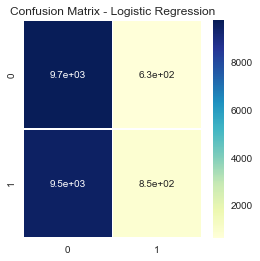

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = range(2), columns = range(2))

plt.figure(figsize=(4,4))
plt.title('Confusion Matrix - Logistic Regression')
sns.heatmap(cm_df, annot = True, linewidths = 0.5, cmap="YlGnBu")

The confusion matrix is telling us that we predicted 9732 + 851 recommendations correctly and 9484 + 626 recommendations incorrectly. 

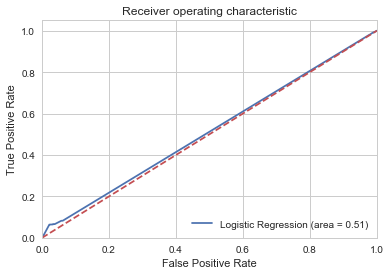

In [19]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
print("The area under the curve is:", roc_auc_score(y_test,logreg.predict_proba(X_test)[:,1]))

The area under the curve is: 0.512471007687721


Logistic regression for our data was not a good fit. Our ROC curve almost no better than a completely random classifier, so we will move on to our next algorithm to see if it works any better.

In [38]:
type(coeffs)

list

##### Feature Importance

In [44]:
coeffs = logreg.coef_
coeffs = coeffs.ravel().tolist()

lr_feat_imp = pd.DataFrame({'feature':cols, 'coefficient': coeffs})

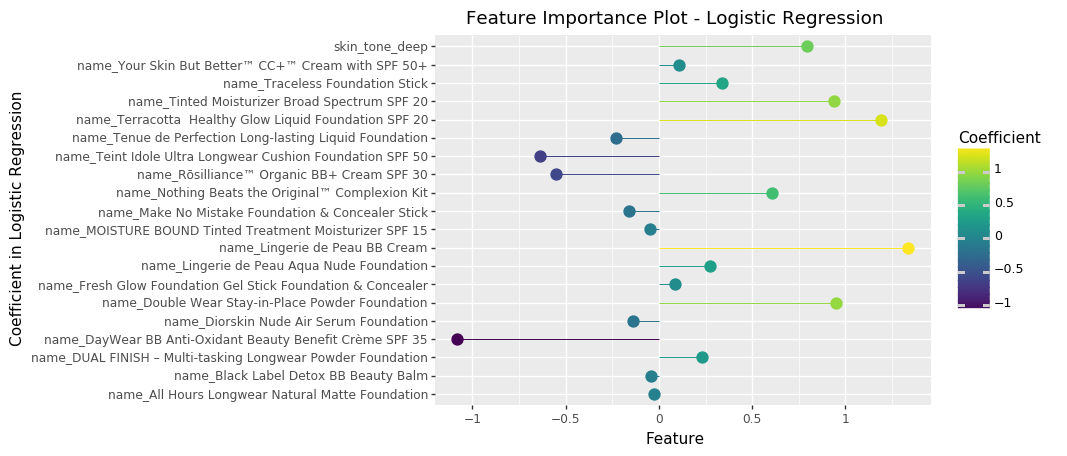

<ggplot: (-9223372029310949302)>

In [57]:
(p9.ggplot(lr_feat_imp, aes(x = 'feature', y = 'coefficient', fill = 'coefficient', color = 'coefficient')) + 
 geom_point(stat = 'identity', size = 4) +
 geom_segment(aes(x = 'feature', xend = 'feature', y = 0, yend = 'coefficient'),
              size = 0.4)+
 coord_flip() + 
 ggtitle('Feature Importance Plot - Logistic Regression') +
 xlab('Coefficient in Logistic Regression') + 
 ylab('Feature')+
 labs(color = 'Coefficient', fill = 'Coefficient'))

As we can see, the most important features are products. One product that has a very negative pull on the logistic regression model is DayWear BB Anti-Oxidant Beauty Benefit Crème SPF 35. However, having a deep skin tone does have a somewhat positive pull on the likelihood of recommendation. It is worth nothing, however, that logistic regression did not work very well and so, we will be working with other models to see if they do a better job of predicting recommendation.

### k-Nearest Neighbors
<a id = 'knn'></a>

Since Logistic Regression sid not return very good success rates, we are going to try k-Nearest Neighbors for our last attempt of predicting recommendations. I have high hopes for this algorithm because it calculates distance between points, and I feel that calculating distance between points may be the best way to match a person's attributes to a product and get their recommendation response.

##### Choosing a k

In [ ]:
neighbors = np.arange(1,250)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In k-Nearest Neighbors, we do get the option of choosing a k, which is how many neighbors we should consider for predicting the recommendation of our test case. We attempted using cross validation to find the optimal k for our KNN where k could be any value from 1 to 250. Unfortunately, the code could not finish running, even after we left it overnight. Once again, I think we could do this if we had more computing power. Perhaps parallel computing would be useful here.

#### Implementation

In [118]:
#get X and y and perform SMOTE over-sampling for no recommendation data
X = df.loc[:, df.columns != 'recommended']
y = df.loc[:, df.columns == 'recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

X_train = os_data_X
y_train = os_data_y['y']

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
print('Accuracy of kNN with 3 nearest neighbors:' + str(knn.score(X_test,y_test)))

Accuracy of kNN with 3 nearest neighbors:0.652368131195692


Even though our code before to iterate over 250 values of k did not work, we were able to test different values of k at 1, 3, 5, 50, and 100 to see which ones produced the highest accuracy scores. At k = 3, the accuracy score was the highest at 65.2368131195692%.

#### Results

In [59]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.37      0.31      3441
           1       0.81      0.73      0.77     12901

   micro avg       0.65      0.65      0.65     16342
   macro avg       0.54      0.55      0.54     16342
weighted avg       0.70      0.65      0.67     16342



We can see that our kNN model works much better than our logistic regression model, but unfortunately, it is very inprecise with predicting a person not recommending a product. However, I would point out that if Sephora gave me a list of recommendations and over 60% of them were products I would like, that would not be the worst success rate. We can still always improve it, so we are going to try one more machine learning algorithm.

##### Confusion Matrix

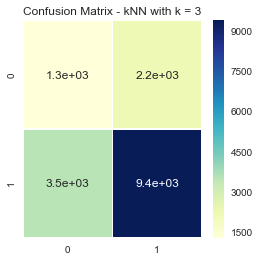

In [60]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = range(2), columns = range(2))

plt.figure(figsize=(4,4))
plt.title('Confusion Matrix - kNN with k = 3')
sns.heatmap(cm_df, annot = True, linewidths = 0.5, cmap="YlGnBu")

This confusion matrix shows that, using kNN, the number of times our model predicted correctly is equal to 1275 + 9386, and the number of times our model predicted incorrectly is 3515 + 2166.

##### ROC Curve

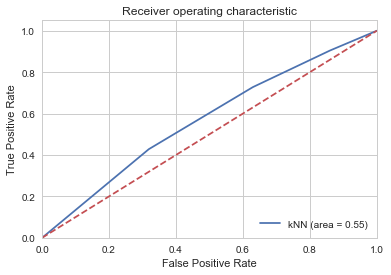

In [63]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#area under curve
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='kNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
print("The area under the curve is:", knn_roc_auc)

The area under the curve is: 0.5490361614405512


While kNN is not anywhere near perfect, it is far superior to logistic regression. It does have an issue of saying people will recommend a product when they actually would not, but even so, if Sephora can get 65% of their recommendations correct for people, that is quite a bit of added revenue.

I would also like to add that if we had more time (and I do plan on coming back to this after the project is due), I am sure that there are more sophisticated machine learning models that could do a better job of predicting recommendation. 

##### Feature Importance 

In [119]:
#names of features
nfeats = list(df.columns)
#get rid of recommendation as a feature
pop = nfeats.pop(1)

#add mean score through iteration
score = []

#get the accuracy of the kNN while dropping each feature
#the less accurate it becomes, the worse the model is
for i in range(len(nfeats)):
    X = X_test.drop(X_test.columns[[i]], axis=1) 
    scores = cross_val_score(knn, X, y_test)
    score.append(scores.mean()) 

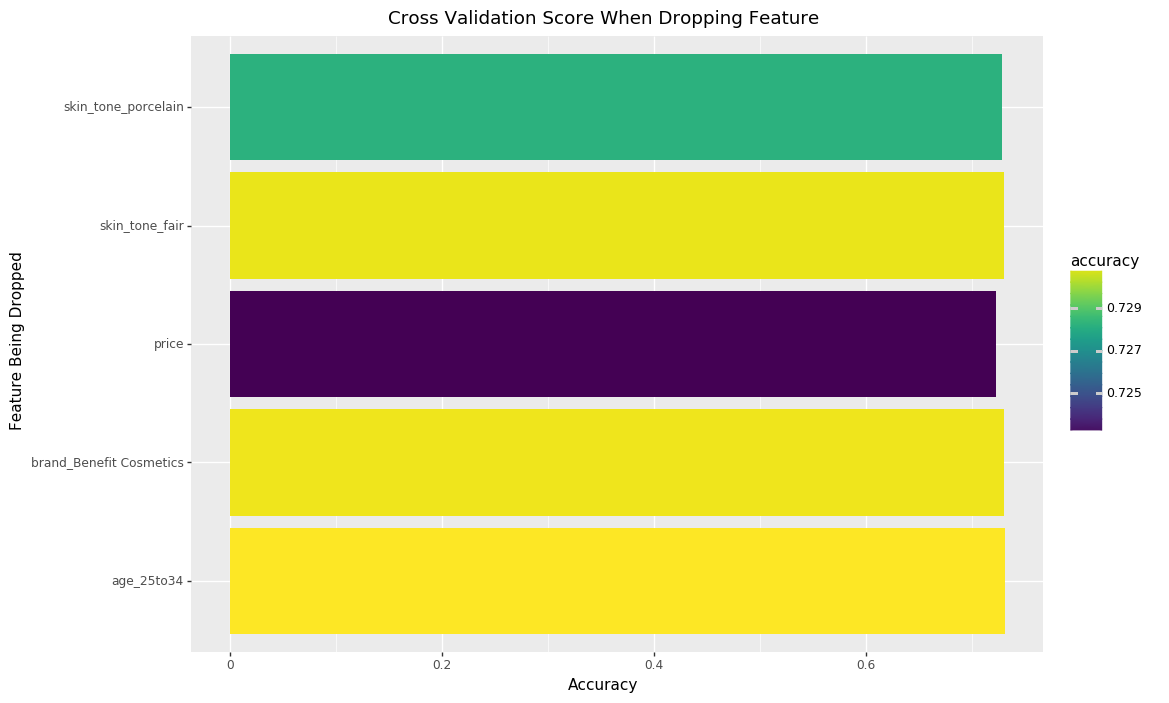

<ggplot: (7534277212)>

In [126]:
knn_score_df = pd.DataFrame({'features': nfeats, 'accuracy': score})
knn_score_df = knn_score_df.sort_values(by = ['accuracy'])
knn_score_df = knn_score_df.head(5)

#plot
(p9.ggplot(knn_score_df, aes(x = 'features', y = 'accuracy', fill = 'accuracy')) + 
 geom_bar(stat = 'identity') + 
 coord_flip() +
 ggtitle('Cross Validation Score When Dropping Feature') + 
 xlab('Feature Being Dropped') + 
 ylab('Accuracy') + 
 theme(figure_size = (11,8)))

For this feature importance plot interpretation, we need to look at it a little differently than the way we looked at our feature importance plot for Logistic Regression. This is because feature importance for logistic regression was calculated by the coefficients to see how each coefficient affected the overall regression.

Here, we are doing something different. We iterated over every single feature we have in our model and saw how much the cross validation score changed for every change. Then, we took the lowest values because the lower the cross validation score was, the more important that feature was to the model. Then, we plotted the five features with the lowest cross validation scores when their feature was dropped from the model. What we see is that price and having a porcelain skin tone actually doe have a more significant impact than some of the other variables. However, most of the variables in the data have a similar level of importance, which can be seen in the data frame. 

What I do like about kNN is that we see some of our features pertaining to characteristics matter, but I believe that we still need to do more testing to be certain.

### Support Vector Machine (SVM)
<a id = 'svm'></a>

#### Changing our Data

In order to do SVM, we are going to make some changes. Because our data is so large, we wanted to reduce the size of it by using a one hot encoder for age. This is because we would have to drop the rows without age values in order to do this, and thus, our dataset would become significantly smaller, so the SVM would not take as long to run. Whether or not this a completely valid action to take is not certain, but we still wanted to try this very popular classification algorithm to see if there was something better than 65% accuracy.

In [170]:
#read in data frame
df = pd.read_csv('/Users/sangeetharamamurthy/Desktop/SephoraFoundationAnalysis/Datasets/sephora_reviews_final.csv')

df = df[['brand','name','skin_type', 'skin_concerns',
        'skin_tone', 'age', 'price', 'recommended']]


df = df[~df['recommended'].isna()]

#0: Not recommended
#1: Recommended
df['recommended'] = [1 if i  == True else 0 for i in df['recommended']]

#one hot encoding for age:
df["age"][df["age"]=="13to17"]=15
df["age"][df["age"]=="18to24"]=21
df["age"][df["age"]=="25to34"]=30
df["age"][df["age"]=="35to44"]=40
df["age"][df["age"]=="45to54"]=50
df["age"][df["age"]=="over54"]=60

#remove all rows ith age as nan
df = df[~df['age'].isna()]

In [171]:
#get dummies for categorical variables
df = pd.get_dummies(df, columns=['brand','name','skin_type', 'skin_tone', 'skin_concerns'], 
                    prefix=['brand','name','skin_type', 'skin_tone','skin_concerns'])

In [172]:
#oversampling training data using SMOTE
#code from: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X = df.loc[:, df.columns != 'recommended']
y = df.loc[:, df.columns == 'recommended']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

#Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no recommendation in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of recommendation",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no recommendation data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of recommendation data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Length of oversampled data is  10474
Number of no recommendation in oversampled data 5237
Number of recommendation 5237
Proportion of no recommendation data in oversampled data is  0.5
Proportion of recommendation data in oversampled data is  0.5


#### Implimentation

#### Results

In [173]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

print('Accuracy of SVM:' + str(svc.score(X_test,y_test)))

Accuracy of SVM:0.7594562647754137


In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.00      0.01       401
           1       0.76      0.99      0.86      1291

   micro avg       0.76      0.76      0.76      1692
   macro avg       0.48      0.50      0.44      1692
weighted avg       0.63      0.76      0.66      1692



Linear SVM seems to be the most accurate out of the three. This is because it has an accuracy of 75.94562647754137%, which is higher than the other two. It is important to note, however, that we did have to drop a lot of the data that we were using before. We cut the total data we were using for this model (training + test) from 80,000 rows to 8,460 rows, and that is very significant. Once again, the reason we had to do this was because SVM takes too long to run, and we also wanted to see if using one-hot-encoding hat any effect on what age did. 

##### Confusion Matrix

Text(16,0.5,'Actual Recommendation')

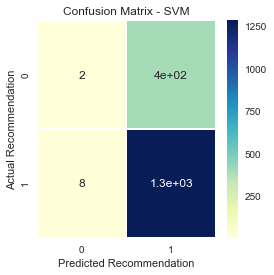

In [175]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = range(2), columns = range(2))

plt.figure(figsize=(4,4))
plt.title('Confusion Matrix - SVM')
sns.heatmap(cm_df, annot = True, linewidths = 0.5, cmap="YlGnBu") 
plt.xlabel('Predicted Recommendation')
plt.ylabel('Actual Recommendation')

The number of correct predictions is 2 + 1283 and the number of incorrect predictions is 8 + 399. Our model is, generally, over-predicting one's and under-predicting zeros.

##### ROC Curve

In [ ]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#area under curve
svc_roc_auc = roc_auc_score(y_test, svc.predict(X_test))
svc.probability = True
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='kNN (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Unfortunately, we could not plot the ROC curve for SVM due to some difficulties with the 'svc.probability' and 'svc.predict_proba(X_test)' lines, which returned an error about probabilit being false. However, we were able to get the area under the ROC curve.

In [183]:
print("The area under the SVM ROC Curve is: ", roc_auc_score(y_test, svc.predict(X_test)))

The area under the SVM ROC Curve is:  0.49939539223204577


Even though the accuracy rate was higher for SVM, the area under the ROC curve is less than 0.5, which does not make much sense. We think that there may be major issues with fitting the SVM algorithm to our data, which we unfortunately do not have more time to explore. Thus, we are going to stick with our kNN model as the best one for now, until we can go back and try additional models.

## Conclusion(s):
<a id = 'conclusion'></a>

kNN is the better algorithm to predict whether or not someone will recommend a product. Thus, if Sephora wants to recommend the best products to people based on their characteristics, it would be wise to use kNN to find items a person is likely to recommend based on the information they gave Sephora when they created my account. If a person is likely to recommend an item, then they will also be likely to like it and thus, Sephora can feel confident in recommending that item to them.

SVM did have a higher success rate, but we used far less data with it, and we also saw that there were some major issues with calculating the area under the roc curve. Thus, we are going to table SVM right now.

While a 65% success rate is not optimal, it is still a decent amount to work with because if Sephora were to recommend ten products to a customer and 6 out of those 10 products were actually products the customer would like, then that would still give Sephora a good chance of getting a purchase out of that person. That being said, I do believe we can increase the success rate of this recommendation predictor in the future with more advanced and sophisticated machine learning algorithms.

It is also possible that some of these features do not have as large of an impact on recommendation and rating as we initially suspected. We would have to do more testing to see if that's the case, but if it is, then it means that no machine learning algorithm will successfully predict what we want.